<a href="https://colab.research.google.com/github/Amr-Mustafa/cnngeometric_pytorch/blob/master/CNNGeometric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
if not os.path.isdir("cnngeometric_pytorch"):
  !git clone https://github.com/Amr-Mustafa/cnngeometric_pytorch
%cd cnngeometric_pytorch/

Cloning into 'cnngeometric_pytorch'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 361 (delta 1), reused 2 (delta 0), pack-reused 356
Receiving objects: 100% (361/361), 69.45 MiB | 31.18 MiB/s, done.
Resolving deltas: 100% (173/173), done.
/content/cnngeometric_pytorch


**Obtaining the Pretrained Models**

In [2]:
trained_models_path = "trained_models"
if not os.path.isdir(trained_models_path):
  os.makedirs(trained_models_path)

if not os.path.exists(os.path.join(os.getcwd(), trained_models_path, "best_streetview_checkpoint_adam_affine_grid_loss_PAMI.pth.tar")):
  !wget -P trained_models http://www.di.ens.fr/willow/research/cnngeometric/trained_models/pytorch/best_streetview_checkpoint_adam_affine_grid_loss_PAMI.pth.tar

if not os.path.exists(os.path.join(os.getcwd(), trained_models_path, "best_streetview_checkpoint_adam_hom_grid_loss_PAMI.pth.tar")):
  !wget -P trained_models http://www.di.ens.fr/willow/research/cnngeometric/trained_models/pytorch/best_streetview_checkpoint_adam_hom_grid_loss_PAMI.pth.tar

if not os.path.exists(os.path.join(os.getcwd(), trained_models_path, "best_streetview_checkpoint_adam_tps_grid_loss_PAMI.pth.tar")):
  !wget -P trained_models http://www.di.ens.fr/willow/research/cnngeometric/trained_models/pytorch/best_streetview_checkpoint_adam_tps_grid_loss_PAMI.pth.tar

--2021-02-05 16:38:47--  http://www.di.ens.fr/willow/research/cnngeometric/trained_models/pytorch/best_streetview_checkpoint_adam_affine_grid_loss_PAMI.pth.tar
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/willow/research/cnngeometric/trained_models/pytorch/best_streetview_checkpoint_adam_affine_grid_loss_PAMI.pth.tar [following]
--2021-02-05 16:38:47--  https://www.di.ens.fr/willow/research/cnngeometric/trained_models/pytorch/best_streetview_checkpoint_adam_affine_grid_loss_PAMI.pth.tar
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-tar]
Saving to: ‘trained_models/best_streetview_checkpoint_adam_affine_grid_loss_PAMI.pth.tar’

best_streetview_che     [       <=>          ]  47.75M  8.84MB/s    in 16s     

20

**Iterative Refinement Using Homographies**

In [3]:
from __future__ import print_function, division
import os
import argparse
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from model.cnn_geometric_model import CNNGeometric
from data.pf_dataset import PFDataset
from data.download_datasets import download_PF_willow
from image.normalization import NormalizeImageDict, normalize_image
from util.torch_util import BatchTensorToVars, str_to_bool
from geotnf.transformation import GeometricTnf
from geotnf.point_tnf import *
import matplotlib.pyplot as plt
from skimage import io
import warnings
from torchvision.transforms import Normalize
from collections import OrderedDict

warnings.filterwarnings('ignore')

In [23]:
feature_extraction_cnn = 'vgg'

if feature_extraction_cnn=='vgg':
    model_aff_path = 'trained_models/best_streetview_checkpoint_adam_affine_grid_loss_PAMI.pth.tar'
    model_tps_path = 'trained_models/best_streetview_checkpoint_adam_tps_grid_loss_PAMI.pth.tar'
    model_hom_path = 'trained_models/best_streetview_checkpoint_adam_hom_grid_loss_PAMI.pth.tar'
elif feature_extraction_cnn=='resnet101':
    model_aff_path = 'trained_models/checkpoint_adam/best_checkpoint_adam_affine_grid_lossresnet101.pth.tar'
    model_tps_path = 'trained_models/checkpoint_adam/best_checkpoint_adam_tps_grid_lossresnet101.pth.tar'   
    model_hom_path = 'trained_models/checkpoint_adam/best_checkpoint_adam_hom_grid_lossresnet101.pth.tar'

source_image_path='CH01173642.jpg'
target_image_path='fixed.jpg'#'CH01173411.jpg'

In [24]:
use_cuda = torch.cuda.is_available()
do_aff = not model_aff_path==''
do_tps = not model_tps_path==''
do_hom = not model_hom_path==''

# Create model
print('Creating CNN model...')
if do_aff:
    model_aff = CNNGeometric(use_cuda=use_cuda, output_dim=6, feature_extraction_cnn=feature_extraction_cnn)
if do_tps:
    model_tps = CNNGeometric(use_cuda=use_cuda, output_dim=18, feature_extraction_cnn=feature_extraction_cnn)
if do_hom:
    model_hom = CNNGeometric(use_cuda=use_cuda, output_dim=8, feature_extraction_cnn=feature_extraction_cnn)

# Load trained weights
print('Loading trained model weights...')
if do_aff:
    checkpoint = torch.load(model_aff_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
    model_aff.load_state_dict(checkpoint['state_dict'])

if do_tps:
    checkpoint = torch.load(model_tps_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
    model_tps.load_state_dict(checkpoint['state_dict'])

if do_hom:
    checkpoint = torch.load(model_hom_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
    model_hom.load_state_dict(checkpoint['state_dict'])

Creating CNN model...
Loading trained model weights...


In [25]:
resizeCNN = GeometricTnf(out_h=240, out_w=240, use_cuda = False) 
normalizeTnf = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def preprocess_image(image):
    # convert to torch Variable
    image = np.expand_dims(image.transpose((2,0,1)),0)
    image = torch.Tensor(image.astype(np.float32)/255.0)
    image_var = Variable(image,requires_grad=False)

    # Resize image using bilinear sampling with identity affine tnf
    image_var = resizeCNN(image_var)
    
    # Normalize image
    image_var = normalize_image(image_var)
    
    return image_var

In [26]:
tpsTnf = GeometricTnf(geometric_model='tps', use_cuda=use_cuda)
affTnf = GeometricTnf(geometric_model='affine', use_cuda=use_cuda)
homTnf = GeometricTnf(geometric_model='hom', use_cuda=use_cuda)

In [27]:
source_image = io.imread(source_image_path)
target_image = io.imread(target_image_path)

source_image_var = preprocess_image(source_image)
target_image_var = preprocess_image(target_image)

if use_cuda:
  source_image_var = source_image_var.cuda()
  target_image_var = target_image_var.cuda()

batch = {'source_image': source_image_var, 'target_image':target_image_var}

resizeTgt = GeometricTnf(out_h=target_image.shape[0], out_w=target_image.shape[1], use_cuda = use_cuda)

In [28]:
if do_aff:
  model_aff.eval()
if do_tps:
  model_tps.eval()
if do_hom:
  model_hom.eval()

In [35]:
# Evaluate models
if do_aff:
  for i in range(3):
    theta_aff = model_aff(batch)
    warped_image_aff = affTnf(batch['source_image'],theta_aff.view(-1,2,3))
    batch['source_image'] = warped_image_aff

batch = {'source_image': source_image_var, 'target_image':target_image_var}

if do_tps:
  for i in range(2):
    theta_tps = model_tps(batch)
    warped_image_tps = tpsTnf(batch['source_image'],theta_tps)
    batch['source_image'] = warped_image_tps

batch = {'source_image': source_image_var, 'target_image':target_image_var} 

batch['source_image'] = warped_image_aff
if do_hom:
  for i in range(3):
    theta_hom = model_hom(batch)
    warped_image_hom = homTnf(batch['source_image'],theta_hom)
    batch['source_image'] = warped_image_hom

batch = {'source_image': source_image_var, 'target_image':target_image_var}

if do_hom and do_tps:
  theta_tps_hom = model_hom({'source_image': warped_image_tps, 'target_image': batch['target_image']})        
  warped_image_tps_hom = homTnf(warped_image_tps, theta_tps_hom)

if do_aff and do_tps:
  theta_aff_tps=model_tps({'source_image': warped_image_aff, 'target_image': batch['target_image']})        
  warped_image_aff_tps = tpsTnf(warped_image_aff,theta_aff_tps)

In [36]:
# Un-normalize images and convert to numpy
if do_aff:
  warped_image_aff_np = normalize_image(resizeTgt(warped_image_aff),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()

if do_tps:
  warped_image_tps_np = normalize_image(resizeTgt(warped_image_tps),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()

if do_hom:
  warped_image_hom_np = normalize_image(resizeTgt(warped_image_hom),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()

if do_hom and do_tps:
  warped_image_tps_hom_np = normalize_image(resizeTgt(warped_image_tps_hom), forward=False).data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()

if do_aff and do_tps:
  warped_image_aff_tps_np = normalize_image(resizeTgt(warped_image_aff_tps),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()

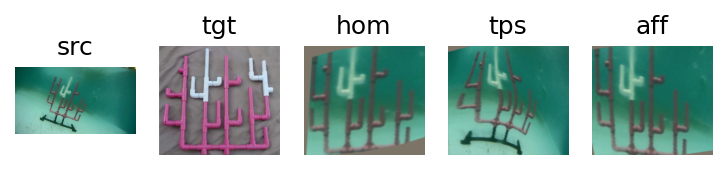

In [37]:
N_subplots = 2+int(do_hom)+int(do_aff)+int(do_tps)#+int(do_aff and do_tps) + int(do_hom and do_tps)
fig, axs = plt.subplots(1,N_subplots)
axs[0].imshow(source_image)
axs[0].set_title('src')
axs[1].imshow(target_image)
axs[1].set_title('tgt')
subplot_idx = 2

if do_hom:
    axs[subplot_idx].imshow(warped_image_hom_np)
    axs[subplot_idx].set_title('hom')
    subplot_idx +=1 

if do_tps:
    axs[subplot_idx].imshow(warped_image_tps_np)
    axs[subplot_idx].set_title('tps')
    subplot_idx +=1 

#if do_hom and do_tps:
#    axs[subplot_idx].imshow(warped_image_hom_tps_np)
#    axs[subplot_idx].set_title('hom+tps')


if do_aff:
    axs[subplot_idx].imshow(warped_image_aff_np)
    axs[subplot_idx].set_title('aff')
    subplot_idx +=1 

#if do_aff and do_tps:
#    axs[subplot_idx].imshow(warped_image_aff_tps_np)
#    axs[subplot_idx].set_title('aff+tps')

for i in range(N_subplots):
    axs[i].axis('off')

fig.set_dpi(150)
plt.show()

In [38]:
io.imsave("warped_image_hom.jpg", warped_image_hom_np)

In [99]:
!python train.py --feature-extraction-cnn resnet101

Namespace(batch_size=16, dataset_csv_path='', dataset_image_path='', fe_finetune_params=[''], feature_extraction_cnn='resnet101', feature_extraction_last_layer='', four_point_hom=True, fr_channels=[225, 128, 64], fr_kernel_sizes=[7, 5, 5], geometric_model='affine', image_size=240, log_dir='', log_interval=100, lr=0.001, lr_max_iter=1000, lr_scheduler=True, matching_type='correlation', model='', momentum=0.9, normalize_matches=True, num_epochs=20, num_workers=4, occlusion_factor=0, random_alpha=0.16666666666666666, random_s=0.5, random_sample=True, random_t=0.5, random_t_tps=0.4, seed=1, test_dataset_size=0, train_bn=True, train_dataset_size=0, train_fe=True, train_fr=True, trained_model_dir='trained_models', trained_model_fn='checkpoint_adam', training_dataset='pascal', update_bn_buffers=False, use_mse_loss=False, weight_decay=0)
Fetching Pascal VOC2011 dataset
[                                                  ]0.0%Traceback (most recent call last):
  File "/usr/local/lib/python3.6/di

In [ ]:
!python demo.py --model-aff trained_models/checkpoint_adam/best_checkpoint_adam_affine_grid_lossresnet101.pth.tar --model-tps '' --feature-extraction-cnn resnet101

In [ ]:
!python train.py --feature-extraction-cnn resnet101 --geometric-model tps --random-t 1.5 --random-s 2 --random-t-tps 0.9 --random-alpha 0.25

In [ ]:
!python demo.py --model-tps trained_models/checkpoint_adam/best_checkpoint_adam_tps_grid_lossresnet101.pth.tar --model-aff '' --feature-extraction-cnn resnet101

In [ ]:
!python train.py --feature-extraction-cnn resnet101 --geometric-model hom

In [ ]:
!python demo.py --model-tps trained_models/checkpoint_adam/best_checkpoint_adam_tps_grid_lossresnet101.pth.tar --model-aff trained_models/checkpoint_adam/best_checkpoint_adam_affine_grid_lossresnet101.pth.tar --feature-extraction-cnn resnet101

In [ ]:
!python train.py --feature-extraction-cnn resnet101 --geometric-model tps --training-dataset caltech